# Capstone Project - Brief Solution

> **Copyright Notice**    
> 
> This IPython notebook is part of the **Deep Dive into Data Science** training program at Nexteer Automotive.  
> It incorporates materials from **Coursera**'s **Deep Learning Specialization**, **TensorFlow: Advanced Techniques Specialization**, and **Mathematics for Machine Learning and Data Science** Specialization, licensed under the **Creative Commons Attribution-ShareAlike 2.0 (CC BY-SA 2.0)**, as well as other sources (including, but not limited to, enhancements developed with the assistance of generative AI tools).  
> All original content created for this program, and all adaptations of source materials, are the intellectual property of Nexteer Automotive and are licensed under the same **Creative Commons Attribution-ShareAlike 2.0 (CC BY-SA 2.0)** license.

## $1.$ Dataset & Objective

### $1.1$ [FordA Dataset](https://www.timeseriesclassification.com/description.php?Dataset=FordA) 

This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination.

| Train Size | Test Size | Length | Number of Classes | Number of Dimensions | Type | 
| -------- | -------- | -------- | -------- | -------- | -------- | 
| 3601  | 1320 | 500 | 2 | 1 | SENSOR |

In [1]:
# Code source: Timeseries classification from scratch - Keras Code Examples 
# Link: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
import numpy as np

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

### $1.2$ Objective

Your objective is to develop a binary classifier that can effectively classify FordA time series dataset. Minimum performance for your choice of metric(s) (i.e., accuracy, precision, recall, F1, etc.) is `90%` on the testing set. **Transfer learning is not premitted**.

A more challenging goal would be exceeding `93%` testing performance while maintaining a generalization gap (overfitting) of less than `4%`.

**Note:** While the state-of-the-art (SOTA) performance on this dataset surpasses these targets, your primary focus should be on solving the problem by applying the techniques you've learned—not outperforming the SOTA.


## $2.$ Model Development

### $2.1$ Data Preparation

* Understand Distribution:  
    * Visualization: Just to give a sense of how data looks like 
* Transform Data:  
    * Normalize: Instance-wise Z-normalization (Z-score) 


**Note**:
Preprocessing for this dataset could have included more advanced techqniues such as *feature engineering, FFT, DTW Averaging,   
Time-Series Data Augmentation*, etc. but they were excluded to limit the scope to architectural design.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import time

In [3]:
def z_scaler(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

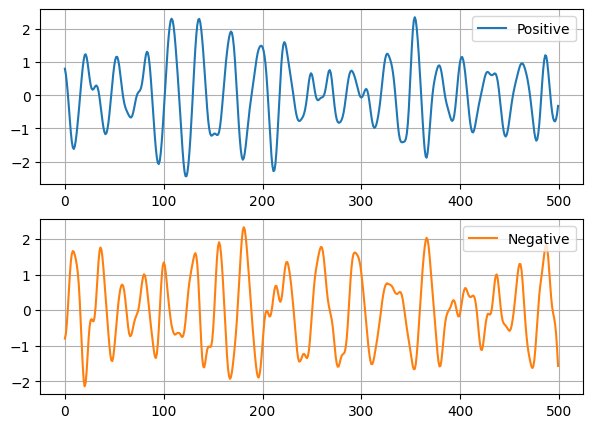

In [4]:
plt.rcParams['figure.figsize'] = [7, 5]
fig, axes = plt.subplots(2, 1)
axes[0].plot(x_train[y_train==1][0], label='Positive')
axes[0].grid(True)
axes[0].legend(loc='upper right')
axes[1].plot(x_train[y_train==-1][0], label='Negative', color='C1')
axes[1].grid(True)
axes[1].legend(loc='upper right')
plt.show()

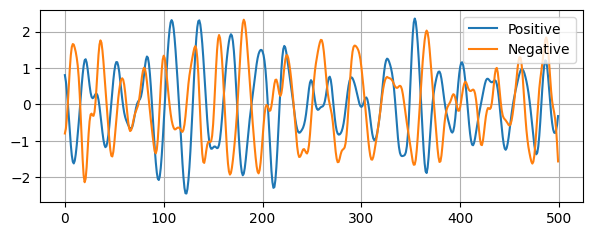

In [5]:
plt.rcParams['figure.figsize'] = [7, 2.5]
plt.plot(x_train[y_train==1][0], label='Positive')
plt.plot(x_train[y_train==-1][0], label='Negative')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Change -1 to 0 in labels
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Normalize
x_train_norm = z_scaler(x_train)
x_test_norm = z_scaler(x_test)

# Double check
pd.DataFrame(x_train_norm).describe().T.round(5)

,count,mean,std,min,25%,50%,75%,max
0,3601.0,0.0,1.00014,-3.70095,-0.63213,0.00863,0.63976,3.32667
1,3601.0,-0.0,1.00014,-3.46243,-0.65058,0.01162,0.65620,3.21799
2,3601.0,-0.0,1.00014,-3.31847,-0.64600,0.01009,0.66765,3.36254
3,3601.0,0.0,1.00014,-3.43756,-0.66939,0.01971,0.66328,3.36308
4,3601.0,0.0,1.00014,-3.59569,-0.65441,0.01052,0.67587,3.15564
...,...,...,...,...,...,...,...,...
495,3601.0,-0.0,1.00014,-3.67472,-0.64067,-0.00734,0.65958,3.50612
496,3601.0,-0.0,1.00014,-3.63493,-0.64644,-0.00471,0.66695,3.43479
497,3601.0,-0.0,1.00014,-3.85561,-0.65457,-0.00295,0.67096,3.75400
498,3601.0,0.0,1.00014,-4.13567,-0.64619,-0.01347,0.67010,3.78468


* Classification metrics:
    * Accuracy
    * F1 Score
    * AUC


### $2.2$ Traning & Validation

#### `F1Score` Class

In [7]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1_score', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [8]:
def plot_loss_metrics(history):
    plt.rcParams['figure.figsize'] = [16, 2.5]
    plt.style.use('seaborn-v0_8-whitegrid')
    metrics = {
        'Loss': ('loss', 'val_loss', 'upper right'),
        'Accuracy': ('binary_accuracy', 'val_binary_accuracy', 'lower right'),
        'F1 Score': ('f1_score', 'val_f1_score', 'lower right'),
        'AUC': ('auc', 'val_auc', 'lower right')
    }
    fig, axes = plt.subplots(1, 4)
    for ax, (title, (train_key, valid_key, legend_loc)) in zip(axes, metrics.items()):
        ax.plot(history.history[train_key], linewidth=2, label='Train')
        ax.plot(history.history[valid_key], linewidth=2, label='Valid')
        ax.legend(loc=legend_loc)
        ax.set_title(title)
        ax.set_ylabel(title)
        ax.set_xlabel('Epoch')

        if title in ['Accuracy', 'F1 Score', 'AUC']:
            ax.set_ylim([0, 1.1])    
    plt.show()

#### 1. Baseline Model

Baseline performance:
* Accuracy: `%77.3`
* F1 score: `%78.1`
* AUC: `%85.9`

##### 1.1 Deal with Bias

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.build((None, 500))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 32)                16032     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
113/113 [==============================] - 1s 4ms/step - loss: 0.6847 - binary_accuracy: 0.6137 - f1_score: 0.6184 - auc: 0.6504 - val_loss: 0.5803 - val_binary_accuracy: 0.6917 - val_f1_score: 0.6772 - val_auc: 0.7596
Epoch 2/50
113/113 [==============================] - 0s 2ms/step - loss: 0.5391 - binary_accuracy: 0.7242 - f1_score: 0.7188 - auc: 0.8035 - val_loss: 0.5411 - val_binary_accuracy: 0.7280 - val_f1_score: 0.7343 - val_auc: 0.8046
Epoch 3/50
113/113 [==============================] - 0s 2ms/step - loss: 0.4858 - binary_accuracy: 0.7681 - f1_score: 0.7658 - auc: 0.8487 - val_loss: 0.5240 - val_binary_accuracy: 0.7439 - val_f1_score: 0.7300 - val_auc: 0.8172
Epoch 4/50
113/113 [==============================] - 0s 2ms/step - loss: 0.4452 - binary_accuracy: 0.8042 - f1_score: 0.7995 - auc: 0.8789 - val_loss: 0.4996 - val_binary_accuracy: 0.7561 - val_f1_score: 0.7476 - val_auc: 0.8360
Epoch 5/50
113/113 [==============================] - 0s 2ms/step - loss: 0.4055

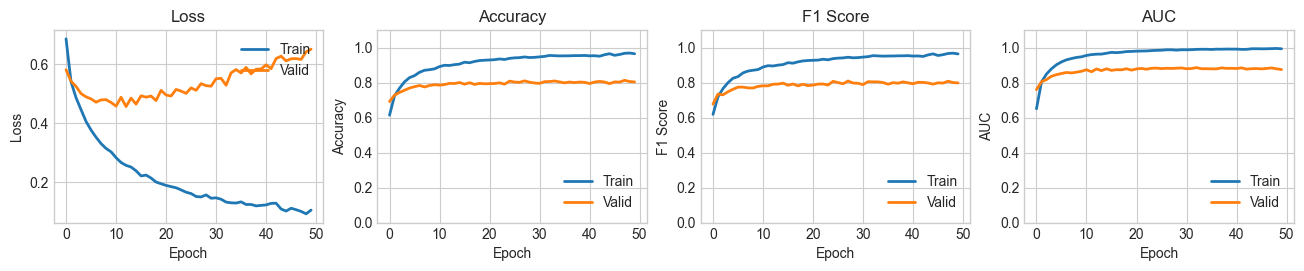

In [10]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        F1Score(),
                        tf.keras.metrics.AUC(),
                ])

history = model.fit(x_train_norm, y_train,
                    validation_data=(x_test_norm, y_test),
                    epochs=50)

plot_loss_metrics(history)

##### 1.2 Deal with Variance: `Dropout`

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.build((None, 500))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 32)                16032     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
113/113 [==============================] - 1s 4ms/step - loss: 0.7572 - binary_accuracy: 0.5837 - f1_score: 0.5644 - auc: 0.6123 - val_loss: 0.5984 - val_binary_accuracy: 0.6697 - val_f1_score: 0.6610 - val_auc: 0.7426
Epoch 2/50
113/113 [==============================] - 0s 2ms/step - loss: 0.6255 - binary_accuracy: 0.6681 - f1_score: 0.6585 - auc: 0.7282 - val_loss: 0.5694 - val_binary_accuracy: 0.7061 - val_f1_score: 0.6945 - val_auc: 0.7767
Epoch 3/50
113/113 [==============================] - 0s 2ms/step - loss: 0.5770 - binary_accuracy: 0.7012 - f1_score: 0.6960 - auc: 0.7730 - val_loss: 0.5600 - val_binary_accuracy: 0.7038 - val_f1_score: 0.6929 - val_auc: 0.7868
Epoch 4/50
113/113 [==============================] - 0s 2ms/step - loss: 0.5481 - binary_accuracy: 0.7223 - f1_score: 0.7196 - auc: 0.7976 - val_loss: 0.5405 - val_binary_accuracy: 0.7348 - val_f1_score: 0.7240 - val_auc: 0.8038
Epoch 5/50
113/113 [==============================] - 0s 2ms/step - loss: 0.5241

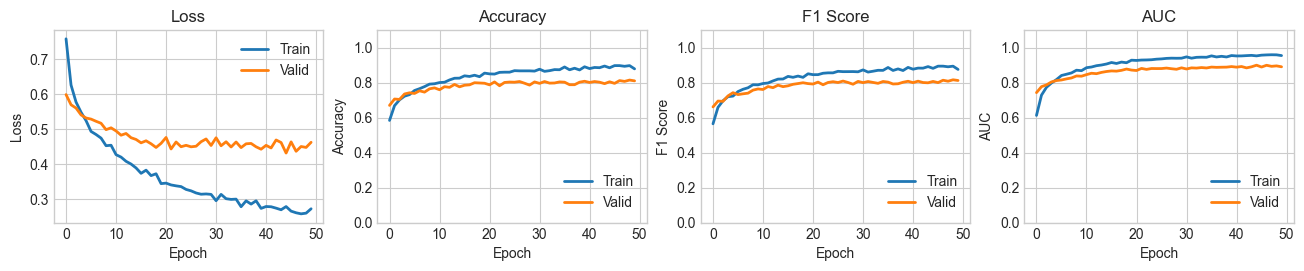

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        F1Score(),
                        tf.keras.metrics.AUC(),
                ])

history_variance = model.fit(x_train_norm, y_train,
                             validation_data=(x_test_norm, y_test),
                             epochs=50)

plot_loss_metrics(history_variance)

##### 1.3 Deal with Variance: `Dropout` + `L2 Regularization`

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.build((None, 500))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 32)                16032     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
113/113 [==============================] - 1s 4ms/step - loss: 1.2517 - binary_accuracy: 0.5682 - f1_score: 0.5261 - auc: 0.5936 - val_loss: 1.0171 - val_binary_accuracy: 0.6735 - val_f1_score: 0.6791 - val_auc: 0.7402
Epoch 2/50
113/113 [==============================] - 0s 2ms/step - loss: 0.9757 - binary_accuracy: 0.6654 - f1_score: 0.6526 - auc: 0.7277 - val_loss: 0.8842 - val_binary_accuracy: 0.6856 - val_f1_score: 0.6905 - val_auc: 0.7709
Epoch 3/50
113/113 [==============================] - 0s 2ms/step - loss: 0.8410 - binary_accuracy: 0.7040 - f1_score: 0.6954 - auc: 0.7772 - val_loss: 0.8015 - val_binary_accuracy: 0.7136 - val_f1_score: 0.7208 - val_auc: 0.7880
Epoch 4/50
113/113 [==============================] - 0s 2ms/step - loss: 0.7637 - binary_accuracy: 0.7298 - f1_score: 0.7233 - auc: 0.7996 - val_loss: 0.7531 - val_binary_accuracy: 0.7098 - val_f1_score: 0.6963 - val_auc: 0.7873
Epoch 5/50
113/113 [==============================] - 0s 2ms/step - loss: 0.7063

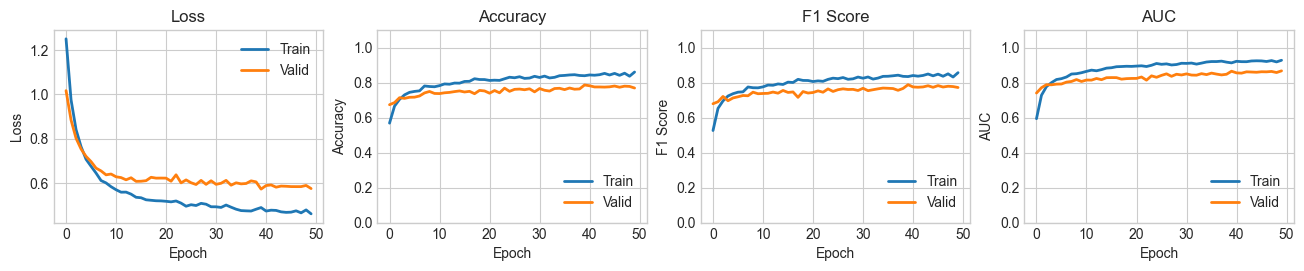

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        F1Score(),
                        tf.keras.metrics.AUC(),
                ])

history_variance2 = model.fit(x_train_norm, y_train,
                              validation_data=(x_test_norm, y_test),
                              epochs=50)

plot_loss_metrics(history_variance2)

#### 2. CNNs 

Starting with simplest network:
* Single `Conv1D` layer with kernel size of `3`

##### 2.1 Deal with Bias

In [9]:
conv_net = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # FCN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_net.build((None, 500))
conv_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           128       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 flatten (Flatten)           (None, 8000)              0         
                                                                 
 dropout (Dropout)           (None, 8000)              0         
                                                                 
 dense (Dense)               (None, 32)                256032    
                                                        

Epoch 1/50
113/113 [==============================] - 2s 7ms/step - loss: 0.6547 - binary_accuracy: 0.6223 - f1_score: 0.5991 - auc: 0.6610 - val_loss: 0.6643 - val_binary_accuracy: 0.5955 - val_f1_score: 0.6599 - val_auc: 0.6754
Epoch 2/50
113/113 [==============================] - 1s 5ms/step - loss: 0.5248 - binary_accuracy: 0.7476 - f1_score: 0.7375 - auc: 0.8225 - val_loss: 0.6515 - val_binary_accuracy: 0.6053 - val_f1_score: 0.6973 - val_auc: 0.7576
Epoch 3/50
113/113 [==============================] - 1s 5ms/step - loss: 0.4487 - binary_accuracy: 0.8087 - f1_score: 0.8034 - auc: 0.8799 - val_loss: 0.7107 - val_binary_accuracy: 0.5720 - val_f1_score: 0.6873 - val_auc: 0.7863
Epoch 4/50
113/113 [==============================] - 1s 5ms/step - loss: 0.3887 - binary_accuracy: 0.8356 - f1_score: 0.8318 - auc: 0.9166 - val_loss: 0.6821 - val_binary_accuracy: 0.6197 - val_f1_score: 0.7115 - val_auc: 0.8306
Epoch 5/50
113/113 [==============================] - 1s 5ms/step - loss: 0.3506

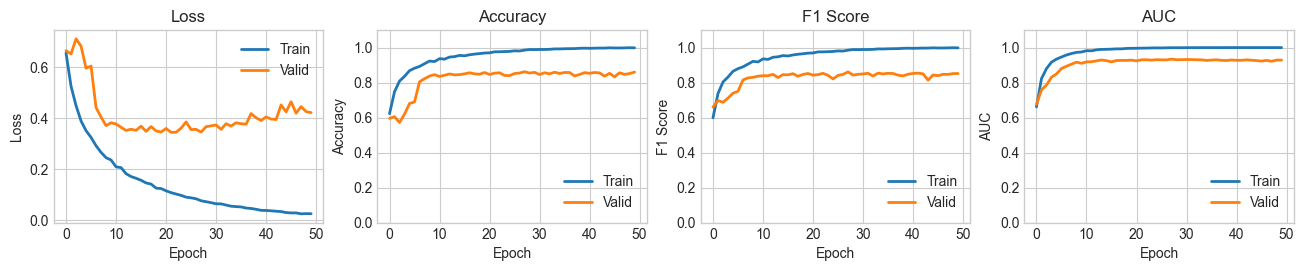

In [10]:
conv_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                 ])

conv_net_history = conv_net.fit(x_train_norm, y_train,
                                validation_data=(x_test_norm, y_test),
                                epochs=50)

plot_loss_metrics(conv_net_history)

##### 2.2 Deal with Variance: `Dropout` + `L2 Regularization`

In [9]:
conv_net = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # FCN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_net.build((None, 500))
conv_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           128       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 flatten (Flatten)           (None, 8000)              0         
                                                                 
 dropout (Dropout)           (None, 8000)              0         
                                                                 
 dense (Dense)               (None, 32)                256032    
                                                        

Epoch 1/50
113/113 [==============================] - 2s 11ms/step - loss: 1.3219 - binary_accuracy: 0.5468 - f1_score: 0.5036 - auc: 0.5600 - val_loss: 1.2720 - val_binary_accuracy: 0.5727 - val_f1_score: 0.6582 - val_auc: 0.6514
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 1.1921 - binary_accuracy: 0.6559 - f1_score: 0.6389 - auc: 0.7138 - val_loss: 1.1940 - val_binary_accuracy: 0.6174 - val_f1_score: 0.6938 - val_auc: 0.7302
Epoch 3/50
113/113 [==============================] - 1s 7ms/step - loss: 1.0937 - binary_accuracy: 0.7045 - f1_score: 0.6920 - auc: 0.7813 - val_loss: 1.1163 - val_binary_accuracy: 0.6856 - val_f1_score: 0.7253 - val_auc: 0.7703
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 1.0359 - binary_accuracy: 0.7234 - f1_score: 0.7123 - auc: 0.8040 - val_loss: 1.0563 - val_binary_accuracy: 0.6992 - val_f1_score: 0.7206 - val_auc: 0.7859
Epoch 5/50
113/113 [==============================] - 1s 7ms/step - loss: 0.976

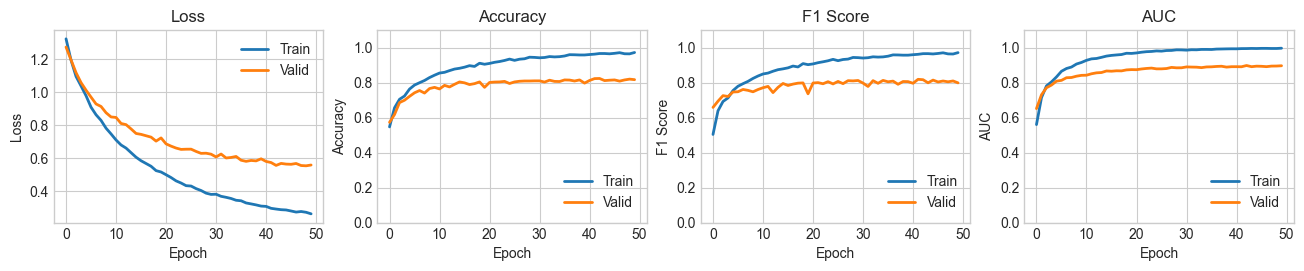

In [10]:
conv_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                 ])

conv_net_history = conv_net.fit(x_train_norm, y_train,
                                validation_data=(x_test_norm, y_test),
                                epochs=50)

plot_loss_metrics(conv_net_history)

#### 3. Deep CNNs

Stacking layers with different kernel sizes to capture patterns (larger to smaller) 
* Kernel sizes of `5` and `3`
* Kernel sizes of `7`, `5` and `3`
* Kernel sizes of `9`, `7`, `5` and `3`
* Kernel sizes of `11`, `9`, `7`, `5` and `3`

##### ~~3.1 Deal with Bias~~

##### 3.2 Deal with Variance: `Dropout` + `L2 Regularization`

##### 3.2.1 Kernel sizes of `5` and `3`

In [9]:
conv_net = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # FCN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_net.build((None, 500))
conv_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           192       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 32)           3104      
                                                                 
 batch_normalization_1 (Batc  (None, 125, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 125, 32)           0

Epoch 1/50
113/113 [==============================] - 2s 10ms/step - loss: 1.3387 - binary_accuracy: 0.5171 - f1_score: 0.4735 - auc: 0.5298 - val_loss: 1.2681 - val_binary_accuracy: 0.5341 - val_f1_score: 0.6393 - val_auc: 0.5981
Epoch 2/50
113/113 [==============================] - 1s 7ms/step - loss: 1.2138 - binary_accuracy: 0.5912 - f1_score: 0.5611 - auc: 0.6399 - val_loss: 1.2100 - val_binary_accuracy: 0.5917 - val_f1_score: 0.6646 - val_auc: 0.6611
Epoch 3/50
113/113 [==============================] - 1s 7ms/step - loss: 1.1295 - binary_accuracy: 0.6518 - f1_score: 0.6338 - auc: 0.7126 - val_loss: 1.1482 - val_binary_accuracy: 0.5742 - val_f1_score: 0.6912 - val_auc: 0.7678
Epoch 4/50
113/113 [==============================] - 1s 7ms/step - loss: 1.0454 - binary_accuracy: 0.7029 - f1_score: 0.6971 - auc: 0.7770 - val_loss: 1.0444 - val_binary_accuracy: 0.7061 - val_f1_score: 0.7503 - val_auc: 0.8247
Epoch 5/50
113/113 [==============================] - 1s 6ms/step - loss: 0.967

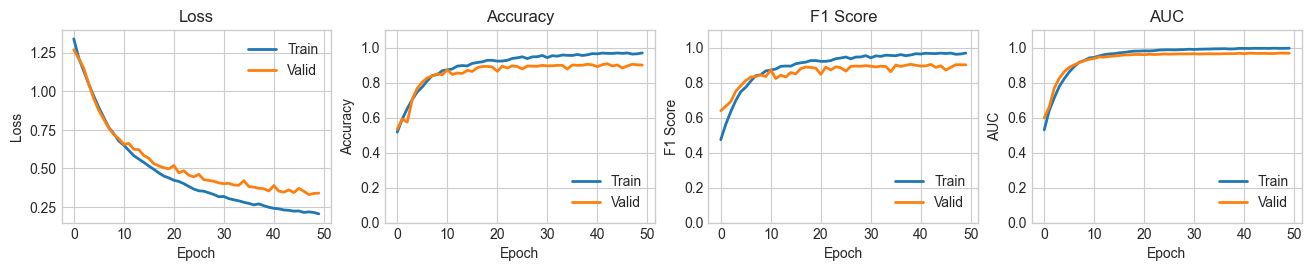

In [10]:
conv_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                 ])

conv_net_history = conv_net.fit(x_train_norm, y_train,
                                validation_data=(x_test_norm, y_test),
                                epochs=50)

plot_loss_metrics(conv_net_history)

##### 3.2.2 Kernel sizes of `7`, `5` and `3`

In [9]:
conv_net = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # FCN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_net.build((None, 500))
conv_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           256       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 32)           5152      
                                                                 
 batch_normalization_1 (Batc  (None, 125, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 125, 32)           0

Epoch 1/50
113/113 [==============================] - 3s 11ms/step - loss: 1.3631 - binary_accuracy: 0.5151 - f1_score: 0.4924 - auc: 0.5388 - val_loss: 1.3089 - val_binary_accuracy: 0.4886 - val_f1_score: 0.6530 - val_auc: 0.5420
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 1.2495 - binary_accuracy: 0.5884 - f1_score: 0.5804 - auc: 0.6406 - val_loss: 1.3020 - val_binary_accuracy: 0.4856 - val_f1_score: 0.6523 - val_auc: 0.6031
Epoch 3/50
113/113 [==============================] - 1s 8ms/step - loss: 1.1529 - binary_accuracy: 0.6662 - f1_score: 0.6712 - auc: 0.7326 - val_loss: 1.2735 - val_binary_accuracy: 0.5053 - val_f1_score: 0.6615 - val_auc: 0.7346
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 1.0512 - binary_accuracy: 0.7270 - f1_score: 0.7355 - auc: 0.8145 - val_loss: 1.1912 - val_binary_accuracy: 0.6023 - val_f1_score: 0.7085 - val_auc: 0.8654
Epoch 5/50
113/113 [==============================] - 1s 9ms/step - loss: 0.951

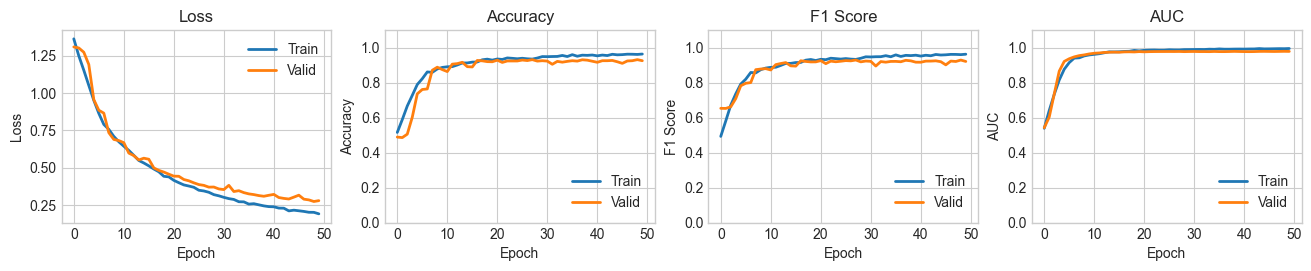

In [10]:
conv_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                 ])

conv_net_history = conv_net.fit(x_train_norm, y_train,
                                validation_data=(x_test_norm, y_test),
                                epochs=50)

plot_loss_metrics(conv_net_history)

##### 3.2.3 Kernel sizes of `9`, `7`, `5` and `3`

In [9]:
conv_net = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # FCN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_net.build((None, 500))
conv_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           320       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 32)           7200      
                                                                 
 batch_normalization_1 (Batc  (None, 125, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 125, 32)           0

Epoch 1/50
113/113 [==============================] - 3s 13ms/step - loss: 1.3646 - binary_accuracy: 0.5171 - f1_score: 0.4820 - auc: 0.5265 - val_loss: 1.2620 - val_binary_accuracy: 0.5364 - val_f1_score: 0.6245 - val_auc: 0.5679
Epoch 2/50
113/113 [==============================] - 1s 10ms/step - loss: 1.2197 - binary_accuracy: 0.5965 - f1_score: 0.5728 - auc: 0.6398 - val_loss: 1.1811 - val_binary_accuracy: 0.6371 - val_f1_score: 0.7095 - val_auc: 0.7182
Epoch 3/50
113/113 [==============================] - 1s 10ms/step - loss: 1.0669 - binary_accuracy: 0.7001 - f1_score: 0.6975 - auc: 0.7858 - val_loss: 1.0040 - val_binary_accuracy: 0.7765 - val_f1_score: 0.7627 - val_auc: 0.8762
Epoch 4/50
113/113 [==============================] - 1s 10ms/step - loss: 0.9192 - binary_accuracy: 0.7942 - f1_score: 0.7883 - auc: 0.8851 - val_loss: 0.8398 - val_binary_accuracy: 0.8462 - val_f1_score: 0.8266 - val_auc: 0.9369
Epoch 5/50
113/113 [==============================] - 1s 11ms/step - loss: 0

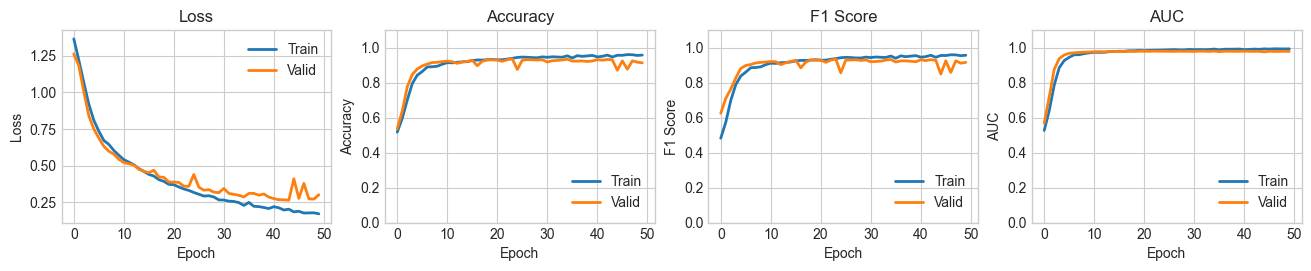

In [10]:
conv_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                 ])

conv_net_history = conv_net.fit(x_train_norm, y_train,
                                validation_data=(x_test_norm, y_test),
                                epochs=50)

plot_loss_metrics(conv_net_history)

##### 3.2.4 Kernel sizes of `11`, `9`, `7`, `5` and `3`

In [9]:
conv_net = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=11, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # FCN
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_net.build((None, 500))
conv_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           384       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 32)           9248      
                                                                 
 batch_normalization_1 (Batc  (None, 125, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 125, 32)           0

Epoch 1/50
113/113 [==============================] - 4s 14ms/step - loss: 0.9509 - binary_accuracy: 0.6146 - f1_score: 0.5000 - auc: 0.7043 - val_loss: 1.0035 - val_binary_accuracy: 0.4841 - val_f1_score: 0.6524 - val_auc: 0.6838
Epoch 2/50
113/113 [==============================] - 1s 11ms/step - loss: 0.8109 - binary_accuracy: 0.7814 - f1_score: 0.7706 - auc: 0.8758 - val_loss: 0.9525 - val_binary_accuracy: 0.5386 - val_f1_score: 0.6724 - val_auc: 0.7741
Epoch 3/50
113/113 [==============================] - 1s 11ms/step - loss: 0.6958 - binary_accuracy: 0.8587 - f1_score: 0.8539 - auc: 0.9403 - val_loss: 0.7691 - val_binary_accuracy: 0.7977 - val_f1_score: 0.8121 - val_auc: 0.9175
Epoch 4/50
113/113 [==============================] - 1s 11ms/step - loss: 0.6239 - binary_accuracy: 0.8873 - f1_score: 0.8835 - auc: 0.9553 - val_loss: 0.6029 - val_binary_accuracy: 0.8924 - val_f1_score: 0.8942 - val_auc: 0.9650
Epoch 5/50
113/113 [==============================] - 1s 11ms/step - loss: 0

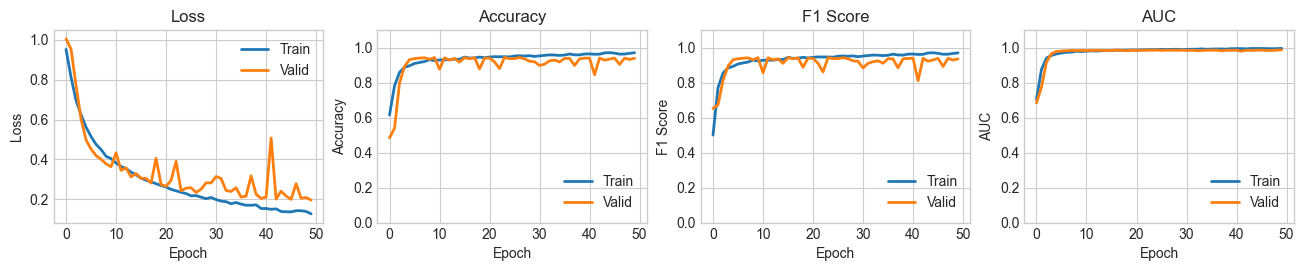

In [10]:
conv_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                 ])

conv_net_history = conv_net.fit(x_train_norm, y_train,
                                validation_data=(x_test_norm, y_test),
                                epochs=50)

plot_loss_metrics(conv_net_history)

#### 4. Hybrid Models (Conv-LSTM)

##### 4.1 Deal with Bias

In [9]:
conv_net = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False)),
    # FCN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_net.build((None, 500))
conv_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           192       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 32)           3104      
                                                                 
 batch_normalization_1 (Batc  (None, 125, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 125, 32)           0

Epoch 1/50
113/113 [==============================] - 8s 37ms/step - loss: 0.6912 - binary_accuracy: 0.5246 - f1_score: 0.3233 - auc: 0.5358 - val_loss: 0.6919 - val_binary_accuracy: 0.5167 - val_f1_score: 0.1821 - val_auc: 0.5340
Epoch 2/50
113/113 [==============================] - 3s 30ms/step - loss: 0.6637 - binary_accuracy: 0.6009 - f1_score: 0.5410 - auc: 0.6726 - val_loss: 0.6876 - val_binary_accuracy: 0.5591 - val_f1_score: 0.6674 - val_auc: 0.6182
Epoch 3/50
113/113 [==============================] - 4s 31ms/step - loss: 0.5829 - binary_accuracy: 0.6948 - f1_score: 0.7386 - auc: 0.7406 - val_loss: 0.7424 - val_binary_accuracy: 0.4841 - val_f1_score: 0.6524 - val_auc: 0.6049
Epoch 4/50
113/113 [==============================] - 4s 31ms/step - loss: 0.4878 - binary_accuracy: 0.7478 - f1_score: 0.7679 - auc: 0.8512 - val_loss: 0.7722 - val_binary_accuracy: 0.4977 - val_f1_score: 0.6581 - val_auc: 0.7128
Epoch 5/50
113/113 [==============================] - 3s 30ms/step - loss: 0

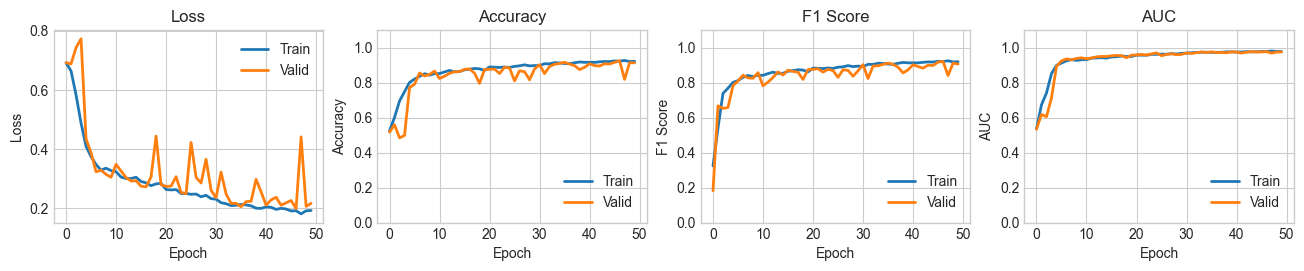

In [10]:
conv_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                 ])

conv_net_history = conv_net.fit(x_train_norm, y_train,
                                validation_data=(x_test_norm, y_test),
                                epochs=50)

plot_loss_metrics(conv_net_history)

##### 4.2 Deal with Variance: `Dropout` + `L2 Regularization`

In [9]:
conv_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train_norm.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False)),
    # FCN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
conv_lstm.build((None, 500))
conv_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 32)           192       
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 32)           3104      
                                                                 
 batch_normalization_1 (Batc  (None, 125, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 125, 32)           0

Epoch 1/50
113/113 [==============================] - 7s 36ms/step - loss: 1.0986 - binary_accuracy: 0.5154 - f1_score: 0.4619 - auc: 0.5288 - val_loss: 1.0784 - val_binary_accuracy: 0.5159 - val_f1_score: 0.0779 - val_auc: 0.4582
Epoch 2/50
113/113 [==============================] - 3s 30ms/step - loss: 1.0472 - binary_accuracy: 0.5640 - f1_score: 0.5407 - auc: 0.5882 - val_loss: 1.0433 - val_binary_accuracy: 0.5152 - val_f1_score: 0.5670 - val_auc: 0.5160
Epoch 3/50
113/113 [==============================] - 3s 30ms/step - loss: 0.9567 - binary_accuracy: 0.6562 - f1_score: 0.6781 - auc: 0.7086 - val_loss: 1.0476 - val_binary_accuracy: 0.4848 - val_f1_score: 0.6516 - val_auc: 0.4878
Epoch 4/50
113/113 [==============================] - 3s 29ms/step - loss: 0.8517 - binary_accuracy: 0.7273 - f1_score: 0.7465 - auc: 0.7988 - val_loss: 1.0917 - val_binary_accuracy: 0.4841 - val_f1_score: 0.6524 - val_auc: 0.5194
Epoch 5/50
113/113 [==============================] - 3s 29ms/step - loss: 0

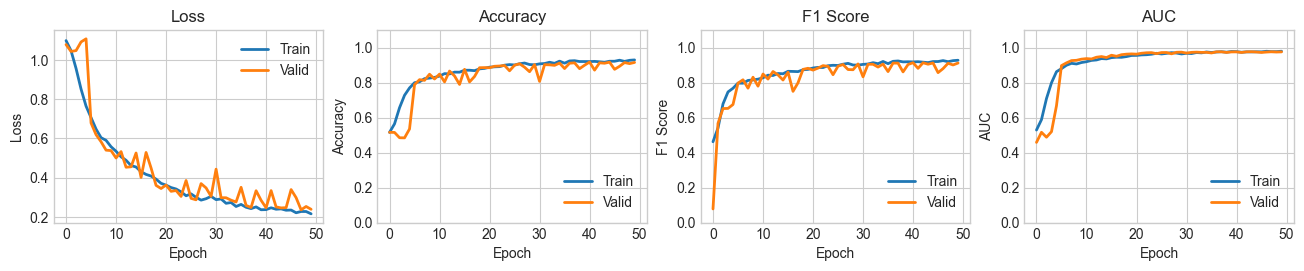

In [10]:
conv_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           F1Score(),
                           tf.keras.metrics.AUC(),
                  ])

conv_lstm_history = conv_lstm.fit(x_train_norm, y_train,
                                  validation_data=(x_test_norm, y_test),
                                  epochs=50)

plot_loss_metrics(conv_lstm_history)

#### 5. ResNet

##### ~~5.1 Deal with Bias~~

##### 5.2 Deal with Variance: `Dropout` + `L2 Regularization`

In [10]:
def identity_block(inputs, filters, kernel_size, strides):
    x = inputs
    # convolutional layer
    x = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    # skip connection
    if inputs.shape[-1] != filters:
        inputs = tf.keras.layers.Conv1D(filters, kernel_size=1, strides=strides, padding='same')(x)
    # merge and final activation
    x = tf.keras.layers.add([x, inputs])
    outputs = tf.keras.layers.Activation('relu')(x)
    return outputs

In [10]:
inputs = tf.keras.Input(shape=(x_train_norm.shape[1], 1))
x = inputs
x = identity_block(x, filters=32, kernel_size=11, strides=1)
x = identity_block(x, filters=32, kernel_size=9, strides=1)
x = identity_block(x, filters=32, kernel_size=7, strides=1)
x = identity_block(x, filters=32, kernel_size=5, strides=1)
x = identity_block(x, filters=32, kernel_size=3, strides=1)
x = identity_block(x, filters=32, kernel_size=2, strides=1)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
res_net = tf.keras.Model(inputs=inputs, outputs=outputs)
res_net.build((None, 500))
res_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 500, 32)      384         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 500, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 500, 32)      0           ['batch_normalization[0][0]']

Epoch 1/50
113/113 [==============================] - 11s 70ms/step - loss: 1.4246 - binary_accuracy: 0.5121 - f1_score: 0.4586 - auc: 0.5203 - val_loss: 1.2789 - val_binary_accuracy: 0.4947 - val_f1_score: 0.6446 - val_auc: 0.5253
Epoch 2/50
113/113 [==============================] - 7s 65ms/step - loss: 1.2440 - binary_accuracy: 0.5432 - f1_score: 0.4675 - auc: 0.5743 - val_loss: 1.2511 - val_binary_accuracy: 0.4841 - val_f1_score: 0.6524 - val_auc: 0.5755
Epoch 3/50
113/113 [==============================] - 7s 66ms/step - loss: 1.1374 - binary_accuracy: 0.6318 - f1_score: 0.6477 - auc: 0.6929 - val_loss: 1.2010 - val_binary_accuracy: 0.5280 - val_f1_score: 0.6719 - val_auc: 0.7298
Epoch 4/50
113/113 [==============================] - 7s 66ms/step - loss: 1.0011 - binary_accuracy: 0.7187 - f1_score: 0.7291 - auc: 0.8117 - val_loss: 1.2041 - val_binary_accuracy: 0.5780 - val_f1_score: 0.6961 - val_auc: 0.8862
Epoch 5/50
113/113 [==============================] - 7s 66ms/step - loss: 

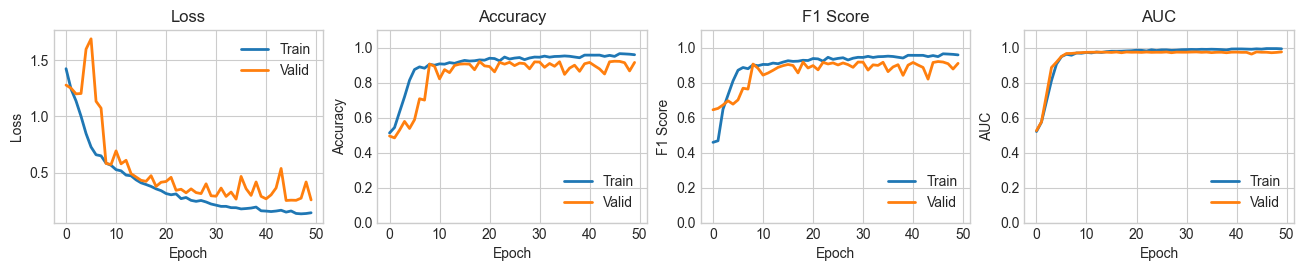

In [11]:
res_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                          F1Score(),
                          tf.keras.metrics.AUC(),
                ])

res_net_history = res_net.fit(x_train_norm, y_train,
                              validation_data=(x_test_norm, y_test),
                              epochs=50)

plot_loss_metrics(res_net_history)

#### 6. Inception

##### ~~6.1 Deal with Bias~~

##### 6.2 Deal with Variance: `Dropout` + `L2 Regularization`

In [9]:
def inception_branch(inputs, kernel_size):
    branch = tf.keras.layers.Conv1D(filters=8, kernel_size=1, padding='same')(inputs)
    branch = tf.keras.layers.BatchNormalization()(branch)
    branch = tf.keras.layers.Activation('relu')(branch)
    branch = tf.keras.layers.Conv1D(filters=16, kernel_size=kernel_size, padding='same')(branch)
    branch = tf.keras.layers.BatchNormalization()(branch)
    outputs = tf.keras.layers.Activation('relu')(branch)
    return outputs

def inception_module(inputs):
    cov_1x_branch = tf.keras.layers.Conv1D(filters=32, kernel_size=1, padding='same')(inputs)
    cov_1x_branch = tf.keras.layers.BatchNormalization()(cov_1x_branch)
    cov_1x_branch = tf.keras.layers.Activation('relu')(cov_1x_branch)

    cov_3x_branch = inception_branch(inputs, kernel_size=3)
    cov_5x_branch = inception_branch(inputs, kernel_size=5)
    cov_7x_branch = inception_branch(inputs, kernel_size=7)
    cov_9x_branch = inception_branch(inputs, kernel_size=9)
    return tf.keras.layers.concatenate([cov_1x_branch, cov_3x_branch, cov_5x_branch, cov_7x_branch, cov_9x_branch], axis=-1)

In [10]:
inputs = tf.keras.Input(shape=(x_train_norm.shape[1], 1))
x = inputs
x = inception_module(x)
x = inception_module(x)
x = inception_module(x)
x = inception_module(x)
x = inception_module(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
inception = tf.keras.Model(inputs=inputs, outputs=outputs)
# inception.build((None, 500))
# inception.summary()

Epoch 1/50
113/113 [==============================] - 38s 216ms/step - loss: 1.1311 - binary_accuracy: 0.5801 - f1_score: 0.6193 - auc: 0.6191 - val_loss: 1.1474 - val_binary_accuracy: 0.4841 - val_f1_score: 0.6524 - val_auc: 0.6245
Epoch 2/50
113/113 [==============================] - 22s 192ms/step - loss: 0.9795 - binary_accuracy: 0.7184 - f1_score: 0.7404 - auc: 0.8110 - val_loss: 1.0993 - val_binary_accuracy: 0.5318 - val_f1_score: 0.6741 - val_auc: 0.8367
Epoch 3/50
113/113 [==============================] - 22s 191ms/step - loss: 0.8755 - binary_accuracy: 0.7801 - f1_score: 0.7842 - auc: 0.8741 - val_loss: 1.0122 - val_binary_accuracy: 0.6788 - val_f1_score: 0.7506 - val_auc: 0.8776
Epoch 4/50
113/113 [==============================] - 22s 191ms/step - loss: 0.7803 - binary_accuracy: 0.8159 - f1_score: 0.8134 - auc: 0.9081 - val_loss: 0.9210 - val_binary_accuracy: 0.7038 - val_f1_score: 0.7652 - val_auc: 0.9217
Epoch 5/50
113/113 [==============================] - 21s 190ms/step

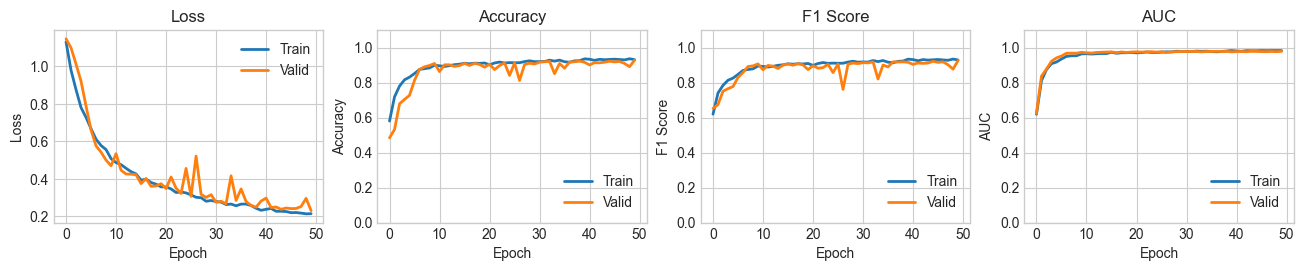

In [ ]:
inception.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           F1Score(),
                           tf.keras.metrics.AUC(),
                  ])

inception_history = inception.fit(x_train_norm, y_train,
                                  validation_data=(x_test_norm, y_test),
                                  epochs=50)

plot_loss_metrics(inception_history)

#### 7. Subclassed Model & Cutom Training Loop

In [9]:
def plot_loss_metrics_custom(train_loss_results, 
                             test_loss_results, 
                             train_accuracy_results,
                             test_accuracy_results,
                             train_f1score_results,
                             test_f1score_results,
                             train_auc_results,
                             test_auc_results):
    plt.rcParams['figure.figsize'] = [16, 2.5]
    plt.style.use('seaborn-v0_8-whitegrid')
    metrics = {
        'Loss': (train_loss_results, test_loss_results, 'upper right'),
        'Accuracy': (train_accuracy_results, test_accuracy_results, 'lower right'),
        'F1 Score': (train_f1score_results, test_f1score_results, 'lower right'),
        'AUC': (train_auc_results, test_auc_results, 'lower right')
    }
    fig, axes = plt.subplots(1, 4)
    for ax, (title, (train_result, test_result, legend_loc)) in zip(axes, metrics.items()):
        ax.plot(train_result, linewidth=2, label='Train')
        ax.plot(test_result, linewidth=2, label='Valid')
        ax.legend(loc=legend_loc)
        ax.set_title(title)
        ax.set_ylabel(title)
        ax.set_xlabel('Epoch')

        if title in ['Accuracy', 'F1 Score', 'AUC']:
            ax.set_ylim([0, 1.1])    
    plt.show()

In [10]:
class MLP(tf.keras.Model):
    def __init__(self, hidden_dense_units=32, dropout_rate=0.1, l2_reg=0.01, **kwargs):
        super(MLP, self).__init__(name="MLP",**kwargs)
        self.hidden_dense_units = hidden_dense_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.fcn = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Dense(self.hidden_dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(self.l2_reg)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    def call(self, inputs):
        return self.fcn(inputs)


class ConvBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters=32, strides=2, **kwargs):
        super(ConvBlock, self).__init__(name="ConvBlock",**kwargs)
        self.kernel_size = kernel_size
        self.filters = filters
        self.strides = strides
        self.conv_block = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size, strides=self.strides, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
        ])
    def call(self, inputs):
        return self.conv_block(inputs)


class ConvNet(tf.keras.Model):
    def __init__(self, kernel_sizes, filters=32, strides=2, hidden_dense_units=32, dropout_rate=0.1, l2_reg=0.01, **kwargs):
        super(ConvNet, self).__init__(name="ConvNet",**kwargs)
        self.kernel_sizes = kernel_sizes
        self.filters = filters
        self.strides = strides
        self.hidden_dense_units = hidden_dense_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.conv_blocks = [ConvBlock(kernel_size, filters=32, strides=2) for kernel_size in self.kernel_sizes]
        self.fcn = MLP(hidden_dense_units=self.hidden_dense_units, dropout_rate=self.dropout_rate, l2_reg=self.l2_reg)
    def call(self, inputs):
        x = inputs
        for block in self.conv_blocks:
            x = block(x)
        return self.fcn(x)

In [11]:
model = ConvNet(kernel_sizes=[11, 9, 7, 5, 3], filters=32, strides=2, hidden_dense_units=32, dropout_rate=0.45, l2_reg=0.01)
model.build((None, 500, 1))
model.summary()

Model: "ConvNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvBlock (ConvBlock)       multiple                  512       
                                                                 
 ConvBlock (ConvBlock)       multiple                  9376      
                                                                 
 ConvBlock (ConvBlock)       multiple                  7328      
                                                                 
 ConvBlock (ConvBlock)       multiple                  5280      
                                                                 
 ConvBlock (ConvBlock)       multiple                  3232      
                                                                 
 MLP (MLP)                   multiple                  1089      
                                                                 
Total params: 26,817
Trainable params: 26,497
Non-trainable

In [12]:
train_ds = (tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
            .cache()
            .batch(64, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
            .cache()
            .batch(64, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [13]:
loss_fn=tf.keras.losses.BinaryCrossentropy()
optimizer=tf.keras.optimizers.Adam(1e-4)
optimizer.build(model.trainable_variables)

Epoch: 00, Loss: 0.6905, Accuracy: 54.58%, F1: 58.21%, AUC: 56.58%, Test Loss: 0.6932, Test Accuracy: 51.41%, Test F1: 64.90%, Test AUC: 49.69%, Time: 6.42s
Epoch: 01, Loss: 0.6232, Accuracy: 65.90%, F1: 66.04%, AUC: 73.13%, Test Loss: 0.6935, Test Accuracy: 48.91%, Test F1: 65.32%, Test AUC: 54.17%, Time: 5.98s
Epoch: 02, Loss: 0.5325, Accuracy: 76.87%, F1: 76.89%, AUC: 86.33%, Test Loss: 0.6835, Test Accuracy: 50.55%, Test F1: 66.06%, Test AUC: 80.39%, Time: 5.95s
Epoch: 03, Loss: 0.4521, Accuracy: 83.84%, F1: 83.20%, AUC: 92.41%, Test Loss: 0.6330, Test Accuracy: 60.47%, Test F1: 70.85%, Test AUC: 91.80%, Time: 5.97s
Epoch: 04, Loss: 0.3886, Accuracy: 87.19%, F1: 86.54%, AUC: 95.07%, Test Loss: 0.5356, Test Accuracy: 72.58%, Test F1: 77.69%, Test AUC: 95.55%, Time: 5.95s
Epoch: 05, Loss: 0.3475, Accuracy: 88.84%, F1: 88.19%, AUC: 95.89%, Test Loss: 0.4345, Test Accuracy: 82.97%, Test F1: 84.84%, Test AUC: 97.13%, Time: 5.89s
Epoch: 06, Loss: 0.3043, Accuracy: 90.96%, F1: 90.51%, AUC

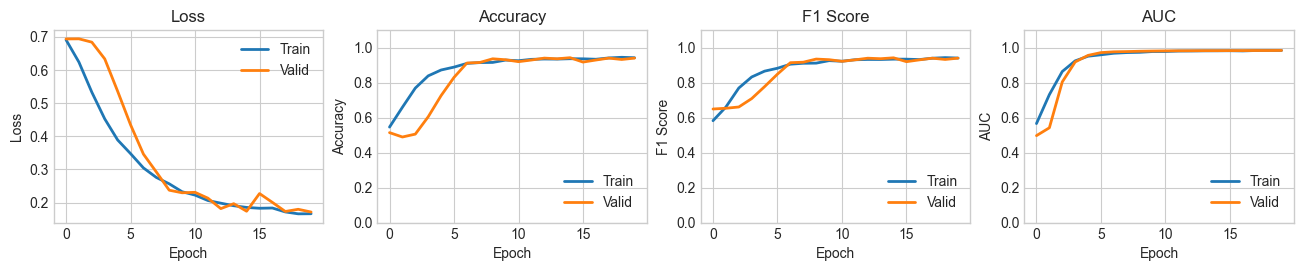

In [18]:
train_loss_results = []
train_accuracy_results = []
train_f1score_results = []
train_auc_results = []

test_loss_results = []
test_accuracy_results = []
test_f1score_resutls = []
test_auc_results = []

EPOCHS = 20
for epoch in range(EPOCHS):
    start_time = time.time()

    ## Training
    # instantiate train metrics
    epoch_avg_loss_train = tf.keras.metrics.Mean()
    epoch_accuracy_train = tf.keras.metrics.BinaryAccuracy()
    epoch_f1score_train = F1Score()
    epoch_auc_train = tf.keras.metrics.AUC()
  
    # loop over train batch
    for x, y in train_ds:
        with tf.GradientTape() as tape:
            # forwardprop
            preds = model(x, training=True)
            # backprop
            loss_values = loss_fn(y_true=y, y_pred=preds)
            grads = tape.gradient(loss_values, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # update epoch metrics
        epoch_avg_loss_train.update_state(loss_values)
        epoch_accuracy_train.update_state(y_true=y, y_pred=preds)
        epoch_f1score_train.update_state(y_true=y, y_pred=preds)
        epoch_auc_train.update_state(y_true=y, y_pred=preds)

    # upadate train (global) metrics
    train_loss_results.append(epoch_avg_loss_train.result())
    train_accuracy_results.append(epoch_accuracy_train.result())
    train_f1score_results.append(epoch_f1score_train.result())
    train_auc_results.append(epoch_auc_train.result())

    ## Validation
    # instantiate test metrics
    epoch_avg_loss_test = tf.keras.metrics.Mean()
    epoch_accuracy_test = tf.keras.metrics.BinaryAccuracy()
    epoch_f1score_test = F1Score()
    epoch_auc_test = tf.keras.metrics.AUC()

    # loop over test batch
    for x_val, y_val in test_ds:
        preds_val = model(x_val, training=False)
        loss_values_val = loss_fn(y_true=y_val, y_pred=preds_val)
        # update epoch metrics
        epoch_avg_loss_test.update_state(loss_values_val)
        epoch_accuracy_test.update_state(y_true=y_val, y_pred=preds_val)
        epoch_f1score_test.update_state(y_true=y_val, y_pred=preds_val)
        epoch_auc_test.update_state(y_true=y_val, y_pred=preds_val)

    # upadate test metrics
    test_loss_results.append(epoch_avg_loss_test.result())
    test_accuracy_results.append(epoch_accuracy_test.result())
    test_f1score_resutls.append(epoch_f1score_test.result())
    test_auc_results.append(epoch_auc_test.result())

    # print results
    compute_time = time.time() - start_time
    print(f"Epoch: {epoch:02d}, "
          f"Loss: {float(epoch_avg_loss_train.result()):.4f}, "
          f"Accuracy: {float(epoch_accuracy_train.result()):.2%}, "
          f"F1: {float(epoch_f1score_train.result()):.2%}, "
          f"AUC: {float(epoch_auc_train.result()):.2%}, "
          f"Test Loss: {float(epoch_avg_loss_test.result()):.4f}, "
          f"Test Accuracy: {float(epoch_accuracy_test.result()):.2%}, "
          f"Test F1: {float(epoch_f1score_test.result()):.2%}, "
          f"Test AUC: {float(epoch_auc_test.result()):.2%}, "
          f"Time: {compute_time:.2f}s")

# plot loss and metrics
plot_loss_metrics_custom(train_loss_results,
                         test_loss_results,
                         train_accuracy_results,
                         test_accuracy_results,
                         train_f1score_results,
                         test_f1score_resutls,
                         train_auc_results,
                         test_auc_results)

In [19]:
del model

model = ConvNet(kernel_sizes=[11, 9, 7, 5, 3], filters=32, strides=2, hidden_dense_units=32, dropout_rate=0.45, l2_reg=0.01)
model.build((None, 500, 1))
model.summary()

Model: "ConvNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvBlock (ConvBlock)       multiple                  512       
                                                                 
 ConvBlock (ConvBlock)       multiple                  9376      
                                                                 
 ConvBlock (ConvBlock)       multiple                  7328      
                                                                 
 ConvBlock (ConvBlock)       multiple                  5280      
                                                                 
 ConvBlock (ConvBlock)       multiple                  3232      
                                                                 
 MLP (MLP)                   multiple                  1089      
                                                                 
Total params: 26,817
Trainable params: 26,497
Non-trainable

In [20]:
loss_fn=tf.keras.losses.BinaryCrossentropy()
optimizer=tf.keras.optimizers.Adam(1e-4)
optimizer.build(model.trainable_variables)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # forwardprop
        preds = model(x, training=True)
        # backprop
        loss_values = loss_fn(y_true=y, y_pred=preds)
        grads = tape.gradient(loss_values, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_values, preds

@tf.function
def test_step(x_val, y_val):
    preds_val = model(x_val, training=False)
    loss_values_val = loss_fn(y_true=y_val, y_pred=preds_val)
    return loss_values_val, preds_val 

Epoch: 00, Loss: 0.6571, Accuracy: 60.41%, F1: 64.78%, AUC: 66.73%, Test Loss: 0.6923, Test Accuracy: 48.12%, Test F1: 64.98%, Test AUC: 69.94%, Time: 3.15s
Epoch: 01, Loss: 0.5456, Accuracy: 76.34%, F1: 77.41%, AUC: 86.41%, Test Loss: 0.6908, Test Accuracy: 48.12%, Test F1: 64.98%, Test AUC: 73.09%, Time: 1.81s
Epoch: 02, Loss: 0.4637, Accuracy: 82.70%, F1: 83.01%, AUC: 91.96%, Test Loss: 0.6831, Test Accuracy: 48.12%, Test F1: 64.98%, Test AUC: 75.04%, Time: 1.73s
Epoch: 03, Loss: 0.4097, Accuracy: 86.69%, F1: 86.62%, AUC: 94.52%, Test Loss: 0.6652, Test Accuracy: 48.91%, Test F1: 65.25%, Test AUC: 78.53%, Time: 1.80s
Epoch: 04, Loss: 0.3597, Accuracy: 88.78%, F1: 88.52%, AUC: 95.71%, Test Loss: 0.6221, Test Accuracy: 55.47%, Test F1: 68.23%, Test AUC: 86.47%, Time: 1.77s
Epoch: 05, Loss: 0.3216, Accuracy: 90.21%, F1: 89.94%, AUC: 96.56%, Test Loss: 0.5842, Test Accuracy: 57.97%, Test F1: 69.50%, Test AUC: 92.91%, Time: 1.85s
Epoch: 06, Loss: 0.2864, Accuracy: 91.13%, F1: 90.86%, AUC

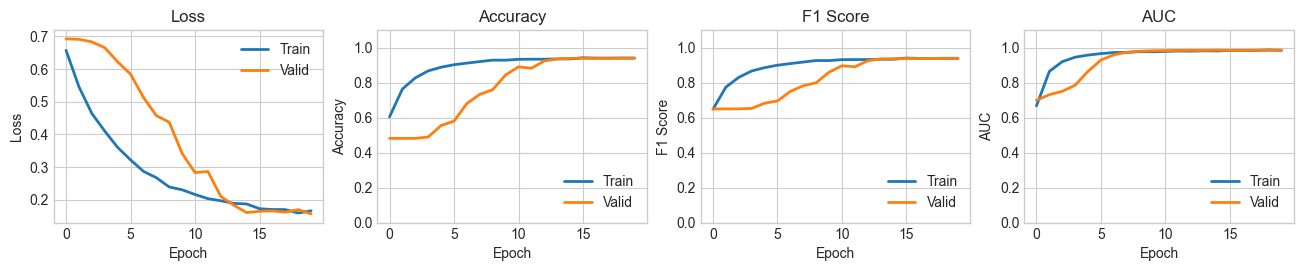

In [21]:
train_loss_results = []
train_accuracy_results = []
train_f1score_results = []
train_auc_results = []

test_loss_results = []
test_accuracy_results = []
test_f1score_resutls = []
test_auc_results = []

EPOCHS = 20
for epoch in range(EPOCHS):
    start_time = time.time()

    ## Train
    # instantiate train metrics
    epoch_avg_loss_train = tf.keras.metrics.Mean()
    epoch_accuracy_train = tf.keras.metrics.BinaryAccuracy()
    epoch_f1score_train = F1Score()
    epoch_auc_train = tf.keras.metrics.AUC()
  
    # loop over train batch
    for x, y in train_ds:
        # foward and backprop
        loss_values, preds = train_step(x, y)
        # update epoch metrics
        epoch_avg_loss_train.update_state(loss_values)
        epoch_accuracy_train.update_state(y_true=y, y_pred=preds)
        epoch_f1score_train.update_state(y_true=y, y_pred=preds)
        epoch_auc_train.update_state(y_true=y, y_pred=preds)

    # upadate train (global) metrics
    train_loss_results.append(epoch_avg_loss_train.result())
    train_accuracy_results.append(epoch_accuracy_train.result())
    train_f1score_results.append(epoch_f1score_train.result())
    train_auc_results.append(epoch_auc_train.result())

    ## Validation
    # instantiate test metrics
    epoch_avg_loss_test = tf.keras.metrics.Mean()
    epoch_accuracy_test = tf.keras.metrics.BinaryAccuracy()
    epoch_f1score_test = F1Score()
    epoch_auc_test = tf.keras.metrics.AUC()

    # loop over test batch
    for x_val, y_val in test_ds:
        loss_values_val, preds_val = test_step(x_val, y_val)
        # update epoch metrics
        epoch_avg_loss_test.update_state(loss_values_val)
        epoch_accuracy_test.update_state(y_true=y_val, y_pred=preds_val)
        epoch_f1score_test.update_state(y_true=y_val, y_pred=preds_val)
        epoch_auc_test.update_state(y_true=y_val, y_pred=preds_val)

    # upadate test metrics
    test_loss_results.append(epoch_avg_loss_test.result())
    test_accuracy_results.append(epoch_accuracy_test.result())
    test_f1score_resutls.append(epoch_f1score_test.result())
    test_auc_results.append(epoch_auc_test.result())

    # print results
    compute_time = time.time() - start_time
    print(f"Epoch: {epoch:02d}, "
          f"Loss: {float(epoch_avg_loss_train.result()):.4f}, "
          f"Accuracy: {float(epoch_accuracy_train.result()):.2%}, "
          f"F1: {float(epoch_f1score_train.result()):.2%}, "
          f"AUC: {float(epoch_auc_train.result()):.2%}, "
          f"Test Loss: {float(epoch_avg_loss_test.result()):.4f}, "
          f"Test Accuracy: {float(epoch_accuracy_test.result()):.2%}, "
          f"Test F1: {float(epoch_f1score_test.result()):.2%}, "
          f"Test AUC: {float(epoch_auc_test.result()):.2%}, "
          f"Time: {compute_time:.2f}s")

# plot loss and metrics
plot_loss_metrics_custom(train_loss_results,
                         test_loss_results,
                         train_accuracy_results,
                         test_accuracy_results,
                         train_f1score_results,
                         test_f1score_resutls,
                         train_auc_results,
                         test_auc_results)